In [1]:
import datetime
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import (GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

%matplotlib inline

## Import data

In [2]:
Data = pd.DataFrame()
xkg = [15,30]
data0 = pd.read_csv("./5000hz/C_v5_none_freq_1_506.csv", header=None)
data0 = data0.iloc[:50, :]
data15 = pd.read_csv("./5000hz/C_v5_mid_15kg_freq.csv", header=None)
data30 = pd.read_csv("./5000hz/C_v5_mid_30kg_freq.csv", header=None)
freqs = pd.read_csv("./5000hz/frequency.csv", header=None).to_numpy()
Data = pd.concat([data0, data15, data30], axis=0)

In [3]:
Data_copy = Data.copy()
freq_precision = (freqs[1] - freqs[0])[0]
select_freq = 5000 # first 5000 Hz energy spectrum are selected
feature_num = int(np.round(select_freq / freq_precision)) + 1  # use the first 5000 Hz data
Data_num = Data_copy.iloc[:, :feature_num]
print('The frequency resolution is: ',np.round(freq_precision,3),'Hz')

The frequency resolution is:  0.076 Hz


In [4]:
X = Data_num.iloc[:, :-1]  # data points
y = Data_copy.iloc[:, -1]  # labels
X.index = range(len(X))
y.index = range(len(y))
# relabel the current labels
le = LabelEncoder()  # encode labels
le = le.fit(y)  # fit labels
y = le.transform(y)  # transform labels
print('There are',X.shape[0],'datapoints, and', X.shape[1],'features in total.')

There are 139 datapoints, and 65536 features in total.


## Data visulization

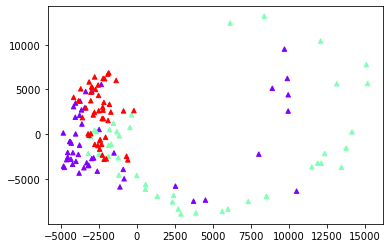

In [5]:
pca = PCA(n_components=2).fit(X)
X_dr = pca.transform(X)
# 2D plot
plt.scatter(X_dr[:, 0], X_dr[:, 1], c=y, cmap="rainbow", marker="^", s=20)
plt.show()

## StandardScaler

In [6]:
# standard scale
scaler = StandardScaler().fit(X)
X_s = scaler.transform(X)
# train_val_test_split 
Xtrain, Xrem, ytrain, yrem = train_test_split(X_s, y, test_size=0.5, random_state=0)
Xval, Xtest, yval, ytest = train_test_split(Xrem, yrem, test_size=0.5, random_state=0)
print('Train size is',Xtrain.shape[0])
print('Validation size is',Xval.shape[0])
print('Test size is',Xtest.shape[0])

Train size is 69
Validation size is 35
Test size is 35


## Logistic Regression

## Feature selection

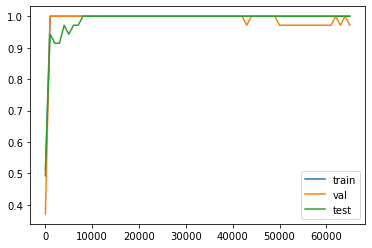

In [7]:
train_score = []
val_score = []
test_score = []
for i in range(1,65537,1000):
    clf_LR = LR(penalty="l2", C=1, fit_intercept=True, solver="lbfgs", n_jobs=-1, random_state=0).fit(Xtrain[:,:i],ytrain)
    LR_train_score = clf_LR.score(Xtrain[:,:i],ytrain)
    LR_var_score = clf_LR.score(Xval[:,:i],yval)
    LR_test_score = clf_LR.score(Xtest[:,:i],ytest)
    train_score.append(LR_train_score)
    val_score.append(LR_var_score)
    test_score.append(LR_test_score)
plt.plot(range(1,65537,1000),train_score)
plt.plot(range(1,65537,1000),val_score)
plt.plot(range(1,65537,1000),test_score)
plt.legend(['train','val','test'])
np.savetxt('train_score.csv',train_score,delimiter=',')
np.savetxt('val_score.csv',val_score,delimiter=',')
np.savetxt('test_score.csv',test_score,delimiter=',')

## Selection of hyperparameter $C$

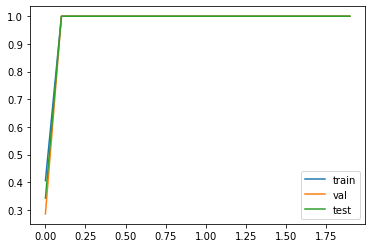

In [8]:
# select the hyperparameter C for LR
train_score = []
val_score = []
test_score = []
loop = np.arange(0,2,0.1)
features = 8001
for i in loop:
    clf_LR = LR(penalty="l2", C=i, fit_intercept=True, solver="lbfgs", n_jobs=-1, random_state=0).fit(Xtrain[:,:features],ytrain)
    LR_train_score = clf_LR.score(Xtrain[:,:features],ytrain)
    LR_var_score = clf_LR.score(Xval[:,:features],yval)
    LR_test_score = clf_LR.score(Xtest[:,:features],ytest)
    train_score.append(LR_train_score)
    val_score.append(LR_var_score)
    test_score.append(LR_test_score)
plt.plot(loop,train_score)
plt.plot(loop,val_score)
plt.plot(loop,test_score)
plt.legend(['train','val','test'])
np.savetxt('train_C.csv',train_score,delimiter=',')
np.savetxt('val_C.csv',val_score,delimiter=',')
np.savetxt('test_C.csv',test_score,delimiter=',')

In [9]:
features = 8001
clf_LR = LR(penalty="l2", C=1.0, fit_intercept=True, solver="lbfgs", n_jobs=-1, random_state=0).fit(Xtrain[:,:features],ytrain)
LR_train_score = clf_LR.score(Xtrain[:,:features],ytrain)
LR_var_score = clf_LR.score(Xval[:,:features],yval)
LR_test_score = clf_LR.score(Xtest[:,:features],ytest)
print("The LR's train accuracy is", LR_train_score)
print("The LR's validation accuracy is", LR_var_score)
print("The LR's test accuracy is", LR_test_score)

The LR's train accuracy is 1.0
The LR's validation accuracy is 1.0
The LR's test accuracy is 1.0


In [10]:
features = 8001
clf_LR_5 = LR(penalty="l2", C=1.0, fit_intercept=True, solver="lbfgs", n_jobs=-1, random_state=0)
c_score = cross_val_score(clf_LR_5, X_s[:,:features], y, cv=5).mean()
print('The 5-folder cross validation score is',round(c_score,3))

The 5-folder cross validation score is 0.964


In [11]:
from sklearn.metrics import log_loss
features = 8001
y_train = clf_LR.predict_proba(Xtrain[:,:features])
y_val = clf_LR.predict_proba(Xval[:,:features])
y_test = clf_LR.predict_proba(Xtest[:,:features])
train_loss = log_loss(ytrain,y_train)
val_loss=log_loss(yval,y_val)
test_loss = log_loss(ytest,y_test)
print('The training log loss is', round(train_loss,3))
print('The validation log loss is', round(val_loss,3))
print('The testing log loss is', round(test_loss,3))

The training log loss is 0.0
The validation log loss is 0.022
The testing log loss is 0.041
